**Assignment Description:**
- In this assignment, I plan to use **topic modeling** to help combat hate speech violence on the Twitter platform, now known as 'X'.
- The dataset is sourced from Kaggle: [Hate Speech and Offensive Tweets by Davidson et al](https://www.kaggle.com/datasets/eldrich/hate-speech-offensive-tweets-by-davidson-et-al).
- I have selected two models for comparison based on their performance on the dataset:
  1. Latent Dirichlet Allocation (LDA)
  2. BERTopic
- Please refer to the technical report for detailed interpretations of the model choices, discussions, and comparisons.

**WARNING: The data contains content that is racist, sexist, homophobic, and offensive.**


# **Topic Modelling using LDA on conbating Hate-speech violence on Twitter platform.**

**Import dataset**

In [ ]:
from google.colab import drive
drive.mount('labeled_data.csv')


Drive already mounted at labeled_data.csv; to attempt to forcibly remount, call drive.mount("labeled_data.csv", force_remount=True).


In [ ]:
import pandas as pd

#Load the CSV file
file_path = '/content/labeled_data.csv/MyDrive/AE2-NLP/Hate speech offensive tweets by Davidson et al/data/labeled_data.csv'
Hate_speech_tweets = pd.read_csv(file_path)

#Keep only target columns (classes information, and the textual information)
review_columns = ['hate_speech', 'offensive_language', 'neither', 'tweet']
new_HST = Hate_speech_tweets[review_columns]

In [ ]:
#load the dataset
new_HST.head()

,hate_speech,offensive_language,neither,tweet
0,0,0,3,!!! RT @mayasolovely: As a woman you shouldn't...
1,0,3,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,0,3,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,0,2,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,0,6,0,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


## **Create a Function for Text Normalization**
### - The function will perform simple cleaning tasks for Exploratory Data Analysis.
- Text Normalization Tasks:
  1. Check for missing values using `.isna()`.
  2. Convert text to lowercase: **`lower_string = string.lower()`**
  3. Remove numbers using a regex pattern: **`pattern = r'[0-9]'`** followed by **`new_string = re.sub(pattern, '', lower_string)`**
  4. Remove punctuation and special characters: **`char.isalnum()`** checks if the character is alphanumeric; non-alphanumeric characters will be removed.

In [ ]:
import string
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
from nltk.stem import PorterStemmer

# Load spaCy
nlp = spacy.load('en_core_web_sm')

# Download NLTK resources
nltk.download("punkt")
nltk.download("wordnet")

def simple_normalised_text(input_text):
    #Check for missing value
    if pd.isna(input_text):
        return ""

    #Lowercase
    lower_string = input_text.lower()

    #Remove numbers
    pattern = r'[0-9]'
    no_numbers_string = re.sub(pattern, '', lower_string)

    #Remove special characters and punctuation
    no_special_chars = ''.join(char for char in no_numbers_string if char.isalnum() or char in string.whitespace)

    return no_special_chars


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Apply Function: **simple_normalised_text** on Dataset for EDA
- Create a copy of the original dataframe (in case something goes wrong): **`.copy()`**
- Name the new dataframe: `new_HST`
- Apply the `simple_normalised_text` function to the `new_HST` on the specific column `[tweet]` (which contains textual data).
- Print the output to check.

In [ ]:
import pandas as pd

#Create a copy of the new_HST
simple_HST = new_HST.copy()

#Apply  function to the 'tweet' column
simple_HST['simple_tweet'] = simple_HST['tweet'].apply(simple_normalised_text)

# Display the first few rows of the DataFrame
print(simple_HST.head())


   hate_speech  offensive_language  neither  \
0            0                   0        3   
1            0                   3        0   
2            0                   3        0   
3            0                   2        1   
4            0                   6        0   

                                               tweet  \
0  !!! RT @mayasolovely: As a woman you shouldn't...   
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...   
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...   
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...   
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...   

                                        simple_tweet  
0   rt mayasolovely as a woman you shouldnt compl...  
1   rt mleew boy dats coldtyga dwn bad for cuffin...  
2   rt urkindofbrand dawg rt sbabylife you ever f...  
3     rt cganderson vivabased she look like a tranny  
4   rt shenikaroberts the shit you hear about me ...  


### Exploratory Analysis: [1]
- To generate a WordCloud using the WordCloud package, it is crucial to have this visualization to understand our dataset.
- The objective of using a WordCloud in this particular task is to gain a broader perspective and understanding of the wordings in this dataset. I will calculate the unique words in the dataset and decide on the range for `max_words` to try and capture a broader frequency range of words.
- The purpose of the WordCloud is to provide an initial understanding of our dataset, especially to help later in manually assessing our LDA Model.
- With 36,455 unique words, considering readability, we have set the `max_words` at 500.

### **WARNING: The data contains content that is racist, sexist, homophobic, and offensive.**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

#calculate the column processed_text
texts = simple_HST['simple_tweet'].values

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

# total number of unique words
unique_words = len(tokenizer.word_index)

print(f"Total number of unique words: {unique_words}")


Total number of unique words: 36455


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


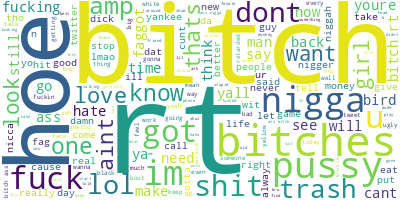

In [ ]:
#Import the wordcloud module
from wordcloud import WordCloud

#Join the different processed titles together.
long_string = ','.join(list(simple_HST['simple_tweet'].values))

#Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='steelblue')

#Generate a word cloud
wordcloud.generate(long_string)

#Visualize the word cloud
wordcloud.to_image()

## Theoretical Overview of LDA:
- LDA (Latent Dirichlet Allocation) is a probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of a set of topic probabilities.
- It makes two assumptions:
  1. Documents are a mixture of topics.
  2. Topics are a mixture of tokens (or words).

- The steps to implement LDA are as follows:
  1. Loading data
  2. Data cleaning
  3. Exploratory analysis
  4. **Preparing data for LDA analysis**
  5. LDA model training
  6. Analyzing LDA model results

## Prepare Text for LDA Analysis [2]
- When applied to text data, LDA decomposes the corpus' document-word matrix (larger matrices) into two smaller matrices: the Document-Topic Matrix and the Topic-Word Matrix.
- In a way, LDA reduces the dimensionality of the dataset.
- Therefore, we apply the `normalised_text` function to prepare the textual data for further LDA analysis.

In [ ]:
import string
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
from nltk.stem import PorterStemmer
import pandas as pd
from nltk.corpus import stopwords

# Load spaCy
nlp = spacy.load('en_core_web_sm')

# Download NLTK resources
nltk.download("punkt")
nltk.download("wordnet")
nltk.download('stopwords')

def normalised_text(input_text):
    # Check for missing value
    if pd.isna(input_text):
        return []

    #Lowercase
    lower_string = input_text.lower()

    #Remove Twitter handles and URLs
    lower_string = re.sub(r'@\w+:', '', lower_string)  # Removes Twitter handles like @mayasolovely:
    lower_string = re.sub(r'http[s]?://\S+', '', lower_string)  # Removes URLs

    #Remove numbers
    no_numbers_string = re.sub(r'[0-9]', '', lower_string)

    #Tokenization
    tokens = word_tokenize(no_numbers_string)

    #Remove special characters and punctuation from tokens
    tokens = [token for token in tokens if token.isalnum()]

    #Load English stopwords
    stop_words = set(stopwords.words('english'))

    #Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]

    #Apply Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Apply the `normalised_text` Function on the Textual Data Column (Tweet)
- Name the new column: `cleaned_HST`

In [ ]:
import pandas as pd

# Assuming 'new_cr' is your DataFrame
# Assuming 'normalised_text' is your function to normalize text

# Create a copy of the original DataFrame
cleaned_HST = new_HST.copy()

# Apply the normalised_text function to the 'reviews.text' column
cleaned_HST['cleaned_HST'] = cleaned_HST['tweet'].apply(normalised_text)

# Display the first few rows of the DataFrame
print(cleaned_HST.head())


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   hate_speech  offensive_language  neither  \
0            0                   0        3   
1            0                   3        0   
2            0                   3        0   
3            0                   2        1   
4            0                   6        0   

                                               tweet  \
0  !!! RT @mayasolovely: As a woman you shouldn't...   
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...   
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...   
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...   
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...   

                                         cleaned_HST  
0  [rt, woman, complain, cleaning, house, amp, ma...  
1  [rt, boy, dat, cold, tyga, dwn, bad, cuffin, d...  
2  [rt, urkindofbrand, dawg, rt, ever, fuck, bitc...  
3                           [rt, look, like, tranny]  
4  [rt, shit, hear, might, true, might, faker, bi...  


## **Prepare a Collection of Preprocessed Text Data for Topic Modeling**
- **`.tolist()`**: Converts the DataFrame column into a list where each element is a document represented as a list of tokens.
-  **Code from the referenced [3] GitHub repository: Introduction to Topic Modeling.ipynb**

In [ ]:
#use gensim.corpora module
import gensim.corpora as corpora

#extract preprocessed documents from df
tweets = cleaned_HST['cleaned_HST'].tolist()

#Create Dictionary
HST_token = corpora.Dictionary(tweets)

#Create Corpus
texts = tweets

#Term Document Frequency
HST_corpus = [HST_token.doc2bow(text) for text in texts]

#View the tweets' word frequency in a readable format
view_HST = HST_corpus[0]
HST_words = [(HST_token[word_id], count) for word_id, count in view_HST]
print(HST_words[:30])



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('always', 1), ('amp', 1), ('cleaning', 1), ('complain', 1), ('house', 1), ('man', 1), ('rt', 1), ('take', 1), ('trash', 1), ('woman', 1)]


## LDA Model Training [3]
- After preparing the text,
- we train the LDA model.
- Our aim is to detect 2 topics as the dataset was pre-labeled into 'hate_speech', 'offensive_language', and 'neither'.
- We will specifically aim to find topics labeled as 'hate_speech' and 'offensive_language'.
- We will use LDA.

In [ ]:
from pprint import pprint
import gensim

# number of topics
num_topics = 3

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=HST_corpus,
                                       id2word=HST_token,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[HST_corpus]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[(0,
  '0.070*"bitch" + 0.067*"rt" + 0.033*"hoe" + 0.012*"like" + 0.012*"pussy" + '
  '0.012*"nigga" + 0.012*"u" + 0.011*"got" + 0.011*"as" + 0.008*"get"'),
 (1,
  '0.058*"bitch" + 0.011*"trash" + 0.009*"pussy" + 0.008*"nigga" + '
  '0.008*"fuck" + 0.006*"rt" + 0.006*"like" + 0.005*"said" + 0.005*"get" + '
  '0.005*"ho"'),
 (2,
  '0.022*"like" + 0.022*"bitch" + 0.018*"rt" + 0.015*"hoe" + 0.011*"nigga" + '
  '0.011*"trash" + 0.009*"shit" + 0.007*"look" + 0.007*"get" + 0.007*"pussy"')]


## **Analyzing our LDA model**
- Now that we have a trained model, we will use **pyLDAvis** to visulase the topics.
- This visualisation tool as major benefits, (1) aiding understanding and to interpreting topics. (2) understanding the relations between the topics;
- I adopt the coding from reference [3]:(1) allow mannual selection topics and view most frequencd and relevant terms. (2) understand how does the topics relate to each other.

In [ ]:
# Install pyLDAvis
!pip install pyldavis


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from pprint import pprint
import gensim
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from IPython.display import display

#Prepare the visualization
LDAvis_prepared = gensimvis.prepare(lda_model, HST_corpus, HST_token)

#Display visualization
pyLDAvis.display(LDAvis_prepared)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Interpret results using Preplexity:
**`.log_perplexity`**

In [ ]:
# Calculate perplexity [4]
print('Perplexity: ', lda_model.log_perplexity(HST_corpus))  #a measure of how well the model predicts new data


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Perplexity:  -7.921707260264309


##Bibliography:

[1] Shashank Kapadia, “Topic Modeling in Python: Latent Dirichlet Allocation (LDA),” Medium, Apr. 15, 2019. [Online]. Available: [https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0) [Accessed Apr. 13, 2024].

[2] N. Seth, “Topic Modeling and Latent Dirichlet Allocation (LDA) using Gensim,” Analytics Vidhya, Jun. 28, 2021. [Online]. Available: [https://www.analyticsvidhya.com/blog/2021/06/part-2-topic-modeling-and-latent-dirichlet-allocation-lda-using-gensim-and-sklearn/](https://www.analyticsvidhya.com/blog/2021/06/part-2-topic-modeling-and-latent-dirichlet-allocation-lda-using-gensim-and-sklearn/) [Accessed Apr. 13, 2024].

[3] Kapadias, “medium-articles/natural-language-processing/topic-modeling/Introduction to Topic Modeling.ipynb at master · kapadias/medium-articles,” GitHub, 2019. [Online]. Available: [https://github.com/kapadias/medium-articles/blob/master/natural-language-processing/topic-modeling/Introduction%20to%20Topic%20Modeling.ipynb](https://github.com/kapadias/medium-articles/blob/master/natural-language-processing/topic-modeling/Introduction%20to%20Topic%20Modeling.ipynb) [Accessed Apr. 13, 2024].

[4] “gensim.models.LdaModel.log_perplexity,” tedboy.github.io. [Online]. Available: [https://tedboy.github.io/nlps/generated/generated/gensim.models.LdaModel.log_perplexity.html](https://tedboy.github.io/nlps/generated/generated/gensim.models.LdaModel.log_perplexity.html) [Accessed Apr. 13, 2024].

[5] “Python math.exp() Method,” www.w3schools.com. [Online]. Available: [https://www.w3schools.com/python/ref_math_exp.asp](https://www.w3schools.com/python/ref_math_exp.asp) [Accessed Apr. 13, 2024].